Name: zixian he

Github Username: zixianh
    
USC ID: 6561586967

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('/kaggle/input/martian-terrain-images/data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1(b) ii.
Data processing section, used to distinguish train, test, val.

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/kaggle/input/martian-terrain-images/train_source_images.txt')
validate_ids = load_text_ids('/kaggle/input/martian-terrain-images/val_source_images.txt')
test_ids = load_text_ids('/kaggle/input/martian-terrain-images/test_source_images.txt')


subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## 1(b) iii.
Shared image loading module, used for loading images and their corresponding labels.

In [4]:
def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                
                # Initalize this dictionary class key if needed
                if image_class not in images.keys():
                    images[image_class] = []
                
                # Load the image, save it to our list
                img = io.imread(fp)
                images[image_class].append(img)

    # Convert list of image arrays into a per-class array
    for key in images.keys():
        images[key] = np.array(images[key])
        
    return images


np_datasets = {
    'train': [],
    'validate': [],
    'test': []
}

logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir, dataset_type in tqdm(zip(subdirs, subdir_splits), desc='Creating Dataset as Numpy array'):
    if dataset_type:  
        full_path = data_head_dir / subdir
        images = load_images(full_path)
        np_datasets[dataset_type].append(images)

Creating Dataset as Numpy array: 414it [04:07,  1.68it/s]


## Print the structure of the datasets data.

In [5]:
# for i in range(56):
#     try:
#         print(np.shape(np_datasets[i]['frost']))
#     except:
#         print(np.shape(np_datasets[i]['background']))
print(np.shape(np_datasets['test'][1]['background']))

(64, 299, 299)


## Data preprocessing for CNN+MLP model

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np


def prepare_data(np_datasets, dataset_type):
    X = []
    y = []

    # Iterate through each sub-list (corresponding to different categories).
    for category in np_datasets[dataset_type]:
        for label, images in category.items():
            for image in images:
                # Add an additional dimension to each image.
                X.append(image)
                y.append(label)

    # Encode the labels as integers."
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded, num_classes = 2)

    return np.array(X), y_categorical


X_train, y_train = prepare_data(np_datasets, 'train')
X_val, y_val = prepare_data(np_datasets, 'validate')
X_test, y_test = prepare_data(np_datasets, 'test')

## Print the shape of y_test to ensure the model is performing on the binary classification datasets.

In [10]:
print(np.shape(y_test))
print(y_test[0][0])

(12823, 2)
1.0


## Shuffle the validation dataset to ensure that gradients can descend uniformly.

In [11]:
from sklearn.utils import shuffle


X_val, y_val = shuffle(X_val, y_val, random_state=0)

## (c) i.
Image augmentation


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1./255)



# train_generator = train_datagen.flow(
#     X_train, y_train,
#     batch_size=32,
#     shuffle=True
# )

# validation_generator = validation_datagen.flow(
#     X_val, y_val,
#     batch_size=32,
#     shuffle=True
# )

## (c) ii.
The model struture of the CNN+MLP.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Train the CNN+MLP model.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)



Epoch 1/20
928/928 [==============================] - 77s 71ms/step - loss: 8.2556 - accuracy: 0.6911 - val_loss: 2.3551 - val_accuracy: 0.8928
Epoch 2/20
928/928 [==============================] - 63s 68ms/step - loss: 2.1881 - accuracy: 0.7136 - val_loss: 4.6206 - val_accuracy: 0.3304
Epoch 3/20
928/928 [==============================] - 63s 68ms/step - loss: 2.1437 - accuracy: 0.7142 - val_loss: 1.5298 - val_accuracy: 0.7797
Epoch 4/20
928/928 [==============================] - 63s 68ms/step - loss: 1.6105 - accuracy: 0.7391 - val_loss: 1.5823 - val_accuracy: 0.8330
Epoch 5/20
928/928 [==============================] - 63s 68ms/step - loss: 2.4237 - accuracy: 0.6666 - val_loss: 1.4467 - val_accuracy: 0.7996
Epoch 6/20
928/928 [==============================] - 63s 68ms/step - loss: 1.3302 - accuracy: 0.7440 - val_loss: 1.9392 - val_accuracy: 0.7244
Epoch 7/20
928/928 [==============================] - 63s 68ms/step - loss: 1.0724 - accuracy: 0.7688 - val_loss: 5.6478 - val_accuracy:

## (c) iii.
Report Precision, Recall, F1 score of the CNN+MLP model.

In [18]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# calculate metrics
report = classification_report(true_classes, predicted_classes)
print(report)

401/401 [==============================] - 6s 14ms/step
              precision    recall  f1-score   support

           0       0.58      0.96      0.73      4418
           1       0.97      0.64      0.77      8405

    accuracy                           0.75     12823
   macro avg       0.78      0.80      0.75     12823
weighted avg       0.84      0.75      0.75     12823



## Output the training accuracy and loss results of the custom-built model.

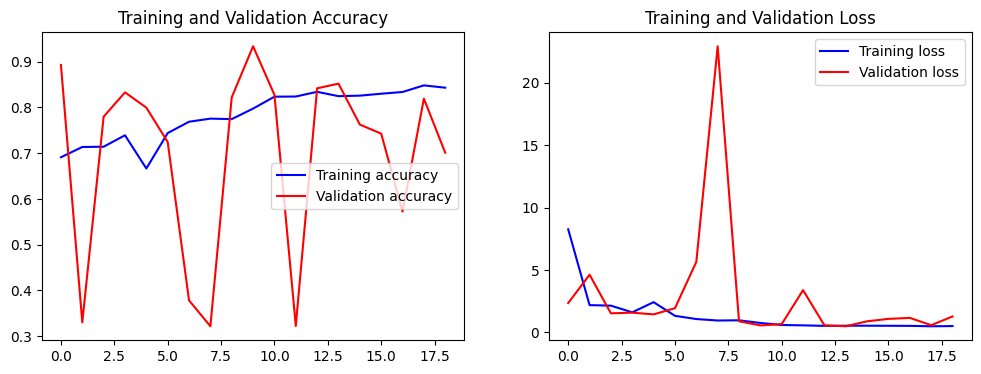

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## VGG16

## (b) i.

In [ ]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('/kaggle/input/martian-terrain-images/data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## (b) ii.

In [ ]:
# Load the subframe names for the three data subsets
train_ids = load_text_ids('/kaggle/input/martian-terrain-images/train_source_images.txt')
validate_ids = load_text_ids('/kaggle/input/martian-terrain-images/val_source_images.txt')
test_ids = load_text_ids('/kaggle/input/martian-terrain-images/test_source_images.txt')


subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## (b) iii.

In [ ]:
def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                
                # Initalize this dictionary class key if needed
                if image_class not in images.keys():
                    images[image_class] = []
                
                # Load the image, save it to our list
                img = io.imread(fp)
                images[image_class].append(img)

    # Convert list of image arrays into a per-class array
    for key in images.keys():
        images[key] = np.array(images[key])
        
    return images



np_datasets = {
    'train': [],
    'validate': [],
    'test': []
}

logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir, dataset_type in tqdm(zip(subdirs, subdir_splits), desc='Creating Dataset as Numpy array'):
    if dataset_type:  
        full_path = data_head_dir / subdir
        images = load_images(full_path)
        np_datasets[dataset_type].append(images)

## (d) ii.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


def prepare_data(np_datasets, dataset_type, reduce_train=False):
    X = []
    y = []

    # Iterate through each sub-list (corresponding to different categories).
    for category in np_datasets[dataset_type]:
        for label, images in category.items():
            for image in images:
                # Convert grayscale images to three-channel images.
                image_3_channels = np.stack((image,)*3, axis=-1)
                X.append(image_3_channels)
                y.append(label)

    # Encode the labels as integers.
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=2)

    X = np.array(X)
    y = y_categorical

    # If you need to reduce the training data by half.
    if reduce_train:
        X, _, y, _ = train_test_split(X, y, test_size=0.7, random_state=42)

    return X, y

# Prepare the data using the modified function.
X_train, y_train = prepare_data(np_datasets, 'train', reduce_train=True)
X_val, y_val = prepare_data(np_datasets, 'validate', reduce_train=True)
X_test, y_test = prepare_data(np_datasets, 'test', reduce_train=True)

from sklearn.utils import shuffle


X_val, y_val = shuffle(X_val, y_val, random_state=0)


## (d) iii.

In [ ]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

np_datasets = []

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# froze base model
base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))  # 2 is the class numbers

## (d) iv.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1./255)


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

## (d) v.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Creating Dataset as Numpy array: 414it [07:22,  1.07s/it]


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/50
1780/1780 [==============================] - 187s 101ms/step - loss: 0.8159 - accuracy: 0.7384 - val_loss: 37.6316 - val_accuracy: 0.6824
Epoch 2/50
1780/1780 [==============================] - 173s 97ms/step - loss: 0.5281 - accuracy: 0.7670 - val_loss: 20.3167 - val_accuracy: 0.6827
Epoch 3/50
1780/1780 [==============================] - 174s 98ms/step - loss: 0.5229 - accuracy: 0.7734 - val_loss: 52.5126 - val_accuracy: 0.6827
Epoch 4/50
1780/1780 [==============================] - 178s 100ms/step - loss: 0.7088 - accuracy: 0.7629 - val_loss: 1.3191 - val_accuracy: 0.3191
Epoch 5/50
1780/1780 [==============================] - 177s 99ms/step - loss: 0.6431 - accuracy: 0.7835 - val_loss: 26.6645 - val_accuracy: 0.6827
Epoch 6/50
1780/1780 [==============================] - 178s 100ms/step - loss: 0.6560 - accuracy: 0.7759 - val_loss: 6.5455 - val_accuracy: 0.3173
Epoch 7/50
1780/1780 [========================

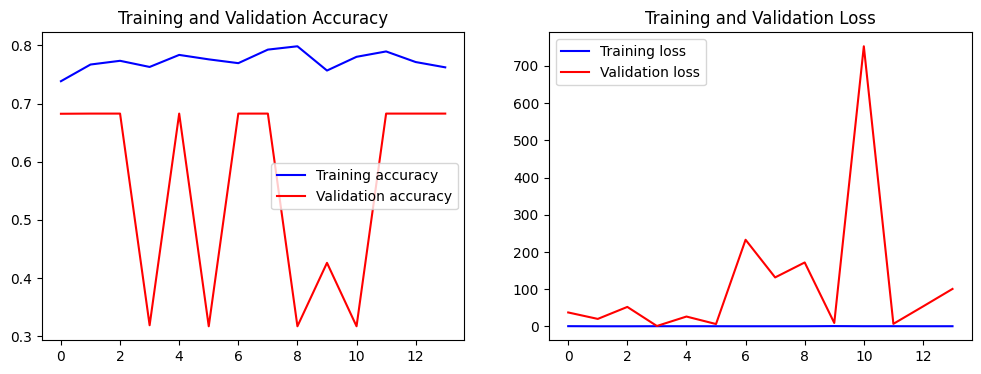

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train),
    batch_size=32,
    steps_per_epoch=len(X_train) // 5,
    epochs=20,
    validation_data=validation_datagen.flow(X_val, y_val),
    callbacks=[early_stopping]
)


predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


report = classification_report(true_classes, predicted_classes)
print(report)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## Compare the results of CNN + MLP model with transfer learning.

### CNN+MLP Model
- **Accuracy**: 75% 
- **Precision**: 
  - Class 0: 58%
  - Class 1: 97%
  - Higher precision for class 1 suggests the model predicts more reliable predictions on this class. However, the predictions of class 0 performs not as good as the predictions of class 1, this could be due to the model overfitting on class 1. Another significant reason is data imbalance, meaning the number of samples in class 1 is disproportionate to those in class 0. This imbalance leads to a shift in the data distribution on the x-axis, causing the model to be more biased towards predicting data for class 1.
- **Recall**: 
  - Class 0: 96%
  - Class 1: 64%
  - The accuracy for class 0 is very low, but the recall is quite high. There are three main reasons for this situation:

1. **Data Imbalance**: The amount of data for class 0 is significantly less than that for class 1.
2. **Model Bias**: During the training process, the model is more sensitive to class 0, which represents the Background. This issue is related to the MLP (Multilayer Perceptron) part of the model.
3. **Inadequate CNN Training**: The CNN (Convolutional Neural Network) part of the model is unable to extract features specific to Frost, leading to the model's inability to distinguish between Frost and Background during training.

- **F1-Score**: 
  - Class 0: 73%
  - Class 1: 77%
  - In general, it is balanced.

### VGG16 Model
- **Accuracy**: 34% 
  - The model did not show improved performance beyond the 14th epoch, so early stopping was implemented.
- **Precision**: 
  - Class 0: 34%
  - Class 1: 100%
  - Results tend to be similar to the CNN+MLP model, and this is due to the imbalance in the dataset, with a low number of samples for the class 0.
- **Recall**: 
  - Class 0: 100%
  - Class 1: 1%
  - The model almost always classifies samples as class 0.
- **F1-Score**: 
  - Class 0: 51%
  - Class 1: 2%

### Summary
- The **CNN+MLP model** shows a more balanced and effective performance overall with higher accuracy, precision, and F1 scores.
- The **VGG16 model** appears to have prediction problems in recognizing class 1. Because of the frozen of the CNN layers, the VGG16 model cannot learn more features from the Frost or Background images, but actually the features of Frost or Background images are hard to learn. Furthermore, during the pretraining phase of VGG16, it has not encountered such images, it was trained on imagenet (because i chose the imagenet weights) which can result in its inability to extract the features of the images in the CNN layers of the Frost or Background images.
